In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Compte rendu de classification
def cpt_mal_classes(y_test_func, result_func):
    nb_func = 0
    for i in range(len(y_test_func)):
        if y_test_func[i] != result_func[i]:
            nb_func += 1
    print (f'Taille des données {len(y_test_func)} mal classés {nb_func}\n')

# Plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
#Path('Output').mkdir(exist_ok=True, parents=True)

### **Recharger les données d'entraînement, de validation et test en fichier numpy**

In [4]:
# Recharger les données après avoir vidé la mémoire
train_X = np.load('Data/train_valid_test/train_X.npy')
train_y = np.load('Data/train_valid_test/train_y.npy')

valid_X = np.load('Data/train_valid_test/valid_X.npy')
valid_y = np.load('Data/train_valid_test/valid_y.npy')
valid_id = np.load('Data/train_valid_test/valid_id.npy')

test_X = np.load('Data/train_valid_test/test_X.npy')
test_id = np.load('Data/train_valid_test/test_id.npy')

train_X = train_X[:,:,:,:].reshape(train_X.shape[0],20,20,-1)
valid_X = valid_X[:,:,:,:].reshape(valid_X.shape[0],20,20,-1)
test_X = test_X[:,:,:,:].reshape(test_X.shape[0],20,20,-1)

### **Encoder les labels entre 0 et 4 de sorte à matcher les prédictions des réseaux de neurones**

In [5]:
encoder = LabelEncoder()
encoder.fit(train_y)
train_y_enc = encoder.transform(train_y)
valid_y_enc = encoder.transform(valid_y)

In [6]:
model = keras.Sequential(
    [
        keras.Input(shape=(20, 20, 2)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(5, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        1632      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 11525     
Total params: 31,653
Trainable params: 31,653
Non-trainable params: 0
_________________________________________________________________


In [7]:
OPTIMIZER = tf.keras.optimizers.Adam(0.001)
BATCH_SIZE = 256
EPOCHS = 2
CALLBACKS = [tf.keras.callbacks.ModelCheckpoint(
              'Model/model',
              verbose=1, # niveau de log
              monitor='val_accuracy', # nom de la métrique à surveiller
              save_best_only=True, # sauver uniquement le meilleur modèle
              save_weights_only=True)] # sauver uniquement les poids

model.compile(loss="sparse_categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])

history = model.fit(train_X, train_y_enc, validation_data=(valid_X,valid_y_enc), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=CALLBACKS)

Epoch 1/2
1765/1766 [============================>.] - ETA: 0s - loss: 0.3784 - accuracy: 0.8706
Epoch 00001: val_accuracy improved from -inf to 0.88467, saving model to Model/model
1766/1766 [==============================] - 85s 48ms/step - loss: 0.3784 - accuracy: 0.8706 - val_loss: 0.2971 - val_accuracy: 0.8847
Epoch 2/2
1765/1766 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9179
Epoch 00002: val_accuracy improved from 0.88467 to 0.89357, saving model to Model/model
1766/1766 [==============================] - 81s 46ms/step - loss: 0.2378 - accuracy: 0.9179 - val_loss: 0.2789 - val_accuracy: 0.8936


In [8]:
model.save('Model/Best_CNN2D')

model_loaded1 = model.load_weights('Model/model')
model_loaded2 = keras.models.load_model('Model/Best_CNN2D')

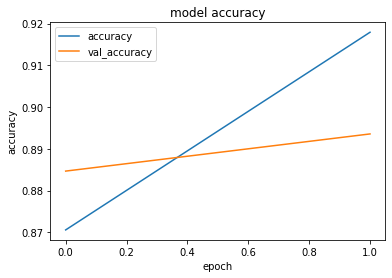

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

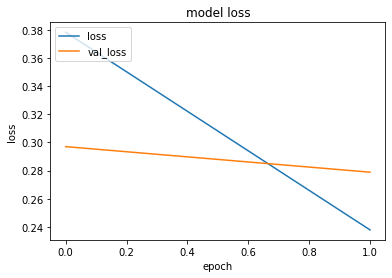

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [11]:
score = model.evaluate(valid_X, valid_y_enc, verbose = 1)

print(f'Loss : {score[0]:.2f}')
print(f'Accuracy : {score[1]:.2f}')

4796/4796 [==============================] - 15s 3ms/step - loss: 0.2789 - accuracy: 0.8936
Loss : 0.28
Accuracy : 0.89


### **Prédiction des classes sur le jeu de validation et évaluation en aggrégeant au niveau objet**

In [12]:
# Récupérer les probabilités prédites sur le jeu de validation
valid_prob = model.predict(valid_X,batch_size=256)

# Retourner la classe correspondant à la probabilité la plus haute
valid_pred = np.argmax(valid_prob,axis=1) # axe 1 car ceci concerne chaque ligne

# Je réencode les prédictions entre 1 et 5
valid_pred_enc = encoder.inverse_transform(valid_pred)

# Aggrégation au niveau objet
out_pred = []
unique_id = np.unique(valid_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = valid_pred_enc[np.where(valid_id==ID)]
    y_true = valid_y[np.where(valid_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    out_pred.append([ np.bincount(y_true).argmax(), np.bincount(pred).argmax()]) #(Vérité terrain,Prédiction majoritaire)
out_pred = np.vstack(out_pred)

In [13]:
cpt_mal_classes(out_pred[:,0], out_pred[:,1])
print(f'F1 score : {f1_score(out_pred[:,0],out_pred[:,1],average="weighted"):.2f}\n')
print(f'Accuracy : {accuracy_score(out_pred[:,1], out_pred[:,0]):.2f}\n')
print(f'Matrice de confusion :\n{confusion_matrix(out_pred[:,0], out_pred[:,1])}\n')
print(f'Classification report :\n{classification_report(out_pred[:,0], out_pred[:,1])}')

Taille des données 558 mal classés 101

F1 score : 0.81

Accuracy : 0.82

Matrice de confusion :
[[  2   4   5   4  14]
 [  0  60  14   7  10]
 [  0   0  41   0   1]
 [  0   0  17  17   3]
 [  0   0   9  13 337]]

Classification report :
              precision    recall  f1-score   support

           1       1.00      0.07      0.13        29
           2       0.94      0.66      0.77        91
           3       0.48      0.98      0.64        42
           4       0.41      0.46      0.44        37
           5       0.92      0.94      0.93       359

    accuracy                           0.82       558
   macro avg       0.75      0.62      0.58       558
weighted avg       0.86      0.82      0.81       558



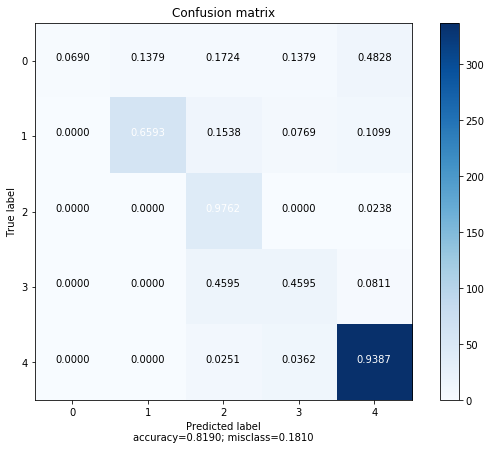

In [14]:
cm = confusion_matrix(out_pred[:,0], out_pred[:,1])
plot_confusion_matrix(cm, None)

### **Prédire sur le jeu test et Préparer une soumission**

In [15]:
# Récupérer les probabilités prédites sur le jeu test
test_prob = model.predict(test_X,batch_size=256)

# Retourner la classe correspondant à la probabilité la plus haute
test_pred = np.argmax(test_prob,axis=1) # axe 1 car ceci concerne chaque ligne

# Je réencode les prédictions entre 1 et 5
test_pred_enc = encoder.inverse_transform(test_pred)

# Aggrégation au niveau objet
agg_pred = []
unique_id = np.unique(test_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = test_pred_enc[np.where(test_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    agg_pred.append([ ID, np.bincount(pred).argmax()]) #(ID,Prédiction majoritaire)
agg_pred = np.vstack(agg_pred)

In [16]:
df = pd.DataFrame({'ID':agg_pred[:,0],'Class':agg_pred[:,1]})
df_test = pd.read_csv('Data/Test_id_Label.csv')

In [17]:
cpt_mal_classes(df_test.Class, df.Class)
print(f'F1 score : {f1_score(df_test.Class,df.Class,average="weighted"):.2f}\n')
print(f'Accuracy : {accuracy_score(df.Class, df_test.Class):.2f}\n')
print(f'Matrice de confusion :\n{confusion_matrix(df_test.Class, df.Class)}\n')
print(f'Classification report :\n{classification_report(df_test.Class, df.Class)}')

Taille des données 800 mal classés 167

F1 score : 0.79

Accuracy : 0.79

Matrice de confusion :
[[  2   5   9   5  21]
 [  0  81  25   9  15]
 [  0   0  59   1   0]
 [  0   0  25  24   5]
 [  0   1  24  22 467]]

Classification report :
              precision    recall  f1-score   support

           1       1.00      0.05      0.09        42
           2       0.93      0.62      0.75       130
           3       0.42      0.98      0.58        60
           4       0.39      0.44      0.42        54
           5       0.92      0.91      0.91       514

    accuracy                           0.79       800
   macro avg       0.73      0.60      0.55       800
weighted avg       0.85      0.79      0.79       800



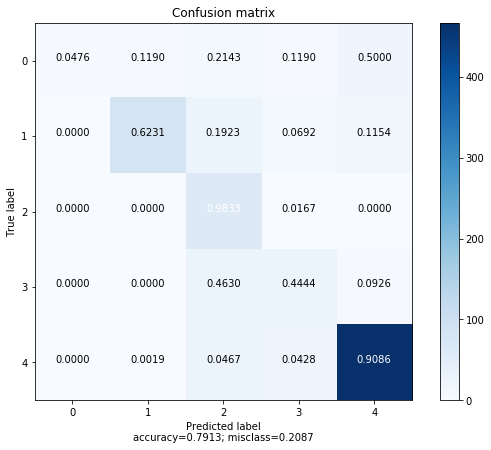

In [18]:
cm = confusion_matrix(df_test.Class, df.Class)
plot_confusion_matrix(cm, None)

# BEFORE
## 100 epochs

In [19]:
# lr = 0.1 -> 0.8697286817613364
# lr = 0.001 -> 0.8997192836881034
# lr = 0.0001 -> 0.8487040808178663

## lr = 0.001

In [20]:
# model.add(Conv2D(128, kernel_size=(2, 2), input_shape=(5, 5, 32))) -> 0.8400641022343117
# model.add(Conv2D(128, kernel_size=(3, 3), input_shape=(5, 5, 32))) -> 0.8761390096224383
# model.add(Conv2D(128, kernel_size=(4, 4), input_shape=(5, 5, 32))) -> 0.8850564403212298
# model.add(Conv2D(128, kernel_size=(5, 5), input_shape=(5, 5, 32))) -> 0.9043562858958935
# model.add(Conv2D(64, kernel_size=(5, 5), input_shape=(5, 5, 32))) -> 0.8623933830390569
# model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(5, 5, 32))) -> 0.8997192836881034
# model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(5, 5, 32))) -> 0.861725146557579

In [21]:
# 0.8990454616150305 model.add(Conv2D(128, kernel_size=(5, 5), input_shape=(5, 5, 32)))
# 0.859862467858344 model.add(Conv2D(64, kernel_size=(5, 5), input_shape=(5, 5, 32)))
# 0.8415452782627942 model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(5, 5, 32)))

# AFTER
## 10 epochs

## FIRST

In [22]:
# 0.8403963187685989

## SECOND

In [23]:
# 0.8581149859321545
# 0.833743064091453

# NEW ONE
## model :

In [24]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=(20, 20, 2)),
#         layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dense(5, activation="softmax")
#     ]
# )
# OPTIMIZER = tf.keras.optimizers.Adam(0.001)
# EPOCHS = 25
# # Taille des données 800 mal classés 117
# # F1 score : 0.86
# # Accuracy : 0.85

# model = keras.Sequential(
#     [
#         keras.Input(shape=(20, 20, 2)),
#         layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
       
#         layers.Dense(5, activation="softmax")
#     ]
# )
# OPTIMIZER = tf.keras.optimizers.Adam(0.01)
# EPOCHS = 25
# # Taille des données 800 mal classés 120
# # F1 score : 0.85
# # Accuracy : 0.85

# # WE NEED TO TRY THIS ONE WITH DROPOUT !!!
# model = keras.Sequential(
#     [
#         keras.Input(shape=(20, 20, 2)),
#         layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(128, kernel_size=(1, 1), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dense(5, activation="softmax")
#     ]
# )
# OPTIMIZER = tf.keras.optimizers.Adam(0.001)
# EPOCHS = 25
# # Taille des données 800 mal classés 134
# # F1 score : 0.83
# # Accuracy : 0.83

# model = keras.Sequential(
#     [
#         keras.Input(shape=(20, 20, 2)),
#         layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.Flatten(),
#         layers.Dense(5, activation="softmax")
#     ]
# )

# model.summary()
# OPTIMIZER = tf.keras.optimizers.Adam(0.001)
# EPOCHS = 25
# # Taille des données 800 mal classés 96
# # F1 score : 0.89
# # Accuracy : 0.88

# model = keras.Sequential(
#     [
#         keras.Input(shape=(20, 20, 2)),
#         layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.Flatten(),
#         layers.Dense(5, activation="softmax")
#     ]
# )

# model.summary()
# OPTIMIZER = tf.keras.optimizers.Adam(0.01)
# EPOCHS = 25
# # Taille des données 800 mal classés 128
# # F1 score : 0.84
# # Accuracy : 0.84